In [9]:
import numpy as np
import pandas as pd
from scipy import signal, optimize
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [10]:
df56k = pd.read_csv('vb_56_android low.csv')
df1k = pd.read_csv('vb1000.csv')

In [11]:
len(df1k)

2812

In [12]:
time = np.arange(0,len(df1k))

In [13]:
df = pd.DataFrame()

In [14]:
df['Time'] = time
df['1000k'] = df1k["Jitter"].values
df['56k'] = df56k["Jitter"][:2812].values

df = df.set_index('Time')
df.index.freq = 'ms'

df.head()

,1000k,56k
Time,,
0,0.000000,0.000000
1,0.689965,1.464125
2,1.341377,1.755673
3,1.951819,2.027818
4,2.523677,2.285573


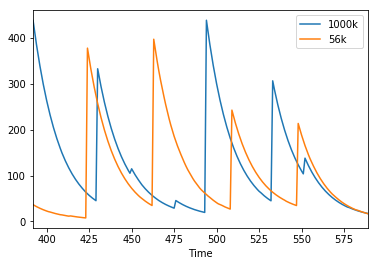

In [15]:
df[392:590].plot()

In [16]:
df.describe()

,1000k,56k
count,2812.000000,2812.000000
mean,100.366901,87.065985
std,117.863522,92.183005
min,0.000000,0.000000
25%,27.133667,25.308020
50%,55.428981,53.585849
75%,122.712843,115.294356
max,728.661757,583.917779


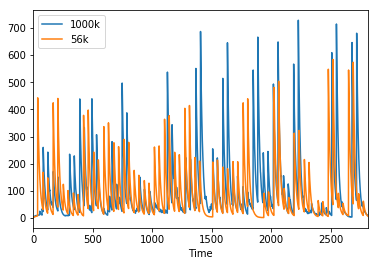

In [22]:
df.plot()

In [8]:
df.describe()

,1000k,56k
count,2812.000000,2812.000000
mean,100.366901,87.065985
std,117.863522,92.183005
min,0.000000,0.000000
25%,27.133667,25.308020
50%,55.428981,53.585849
75%,122.712843,115.294356
max,728.661757,583.917779


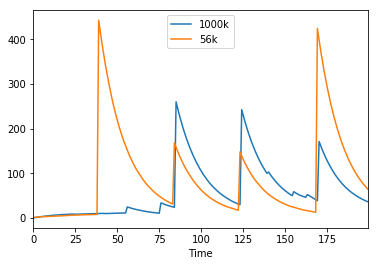

In [16]:
df[:200].plot()

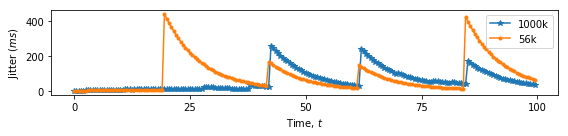

In [198]:
fig, axe = plt.subplots(figsize=(8,2))
axe.plot(df['1000k'][:200], ls='-', marker='*')
axe.plot(df['56k'][:200], ls='-', marker='.')
#axe.plot(x3, label='Data with low, intermediate and high congestion', ls='-', marker='*')


l = [0, 50.0, 100.0, 150.0, 200.0]
lx = ['0', '25', '50', '75', '100']
axe.set_xticks(l)
axe.set_xticklabels(lx)
axe.set_xlabel("Time, $t$")
#axe.axes.yaxis.set_ticks([])

axe.set_ylabel("Jitter $(ms)$")
axe.legend()

fig.tight_layout()
fig.savefig('bitrates.pdf', format='pdf', dpi=2000);

In [190]:
df.head()

,1000k,56k
Time,,
0,0.000000,0.000000
1,0.689965,1.464125
2,1.341377,1.755673
3,1.951819,2.027818
4,2.523677,2.285573


## 56K

In [23]:
def func(x,a,b):
    return a*np.exp(b*x)

In [24]:
x56 = df['56k'][:200].values

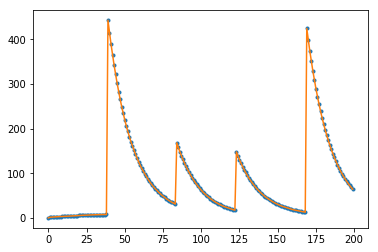

In [25]:
plt.plot(x56, '.')
plt.plot(x56, '-')

In [69]:
N56 = len(x56)
t56 = np.linspace(0,100,N56)

In [28]:
len(t56)

56

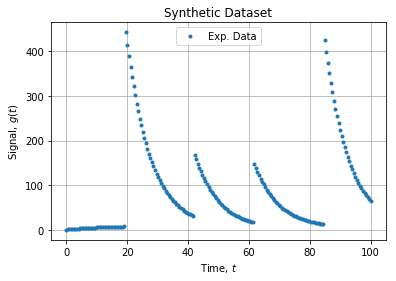

In [70]:
fig, axe = plt.subplots()
axe.plot(t56, x56, '.', label='Exp. Data')
#axe.plot(t, x, '-', label='Exact')
axe.set_title("Synthetic Dataset")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Signal, $g(t)$")
axe.legend()
axe.grid()

In [71]:
dx56dt = np.abs(np.diff(x56)/np.diff(t56))

In [75]:
x56it = 70

In [76]:
q56 = np.where(dx56dt > x56it)
q56

(array([ 38,  83, 122, 168], dtype=int64),)

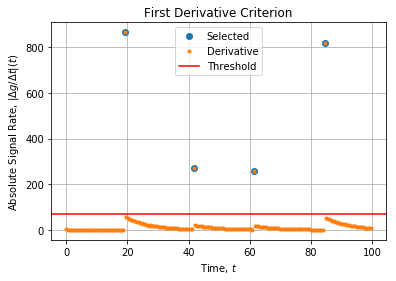

In [77]:
fig, axe = plt.subplots()
axe.plot(t56[q56[0]], dx56dt[q56[0]], 'o', label='Selected')
axe.plot(t56[:-1], dx56dt, '.', label='Derivative')
axe.axhline(x56it, color="red", label='Threshold')
axe.set_title("First Derivative Criterion")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Absolute Signal Rate, $|\Delta g/\Delta t|(t)$")
axe.legend()
axe.grid()

In [78]:
idx56 = [0] + list(q56[0]+1) + [t56.size]
idx56

[0, 39, 84, 123, 169, 200]

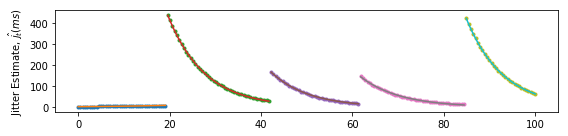

In [204]:
trials56 = []
fig, axe = plt.subplots(figsize=(8,2))
for k, (i, j) in enumerate(zip(idx56[:-1], idx56[1:])):
    p, s = optimize.curve_fit(func, t56[i:j]-t56[i], x56[i:j])
    axe.plot(t56[i:j], x56[i:j], '.', label="Data #{}".format(k+1))
    axe.plot(t56[i:j], func(t56[i:j]-t56[i], *p), label="Curve Fit #{}".format(k+1))
    trials56.append({"n0": i, "n1": j, "t0": t56[i], "a": p[0], "b": p[1],
                   "s_a": s[0,0], "s_b": s[1,1], "s_ab": s[0,1]})
#axe.set_title("Curve Fits")
#axe.set_xlabel("Time, $t$")
axe.set_ylabel("Jitter Estimate, $\hat{j_t}(ms)$")
#axe.axes.yaxis.set_ticks([])
#axe.legend()
fig.tight_layout()
fig.savefig('56k.pdf', format='pdf', dpi=2000);
#axe.grid()

In [176]:
rmse56 = []
for i, j in zip(idx56[:-1], idx56[1:]):
    p, s = optimize.curve_fit(func, t56[i:j]-t56[i], x56[i:j])
    rmse = np.sqrt(np.mean((x56[i:j]-func(t56[i:j]-t56[i], *p))**2))
    rmse56.append({"n0": i, "n1": j, "rmse": rmse})

In [177]:
df56 = pd.DataFrame(rmse56)
df56

,n0,n1,rmse
0,0,39,0.645944
1,39,84,1.628589
2,84,123,0.508225
3,123,169,1.324166
4,169,200,0.506139


In [178]:
df56['rmse'].sum()

4.613062072735296

In [208]:
from sklearn.metrics import mean_absolute_error

In [209]:
mae56 = []

for i, j in zip(idx56[:-1], idx56[1:]):
    p, s = optimize.curve_fit(func, t56[i:j]-t56[i], x56[i:j])
    mae = mean_absolute_error(x56[i:j],(func(t56[i:j]-t56[i], *p)))
    mae56.append({"n0": i, "n1": j, "mae": mae})

In [210]:
mae56

[{'n0': 0, 'n1': 39, 'mae': 0.48144406060135897},
 {'n0': 39, 'n1': 84, 'mae': 1.423377253193529},
 {'n0': 84, 'n1': 123, 'mae': 0.41410408072230465},
 {'n0': 123, 'n1': 169, 'mae': 1.1479159747801326},
 {'n0': 169, 'n1': 200, 'mae': 0.43386764329476996}]

In [211]:
df56mae = pd.DataFrame(mae56)
df56mae['mae'].sum()

3.900709012592095

## 1000k 

In [84]:
x1k = df['1000k'][:200].values

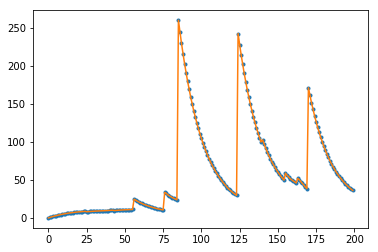

In [85]:
plt.plot(x1k, '.')
plt.plot(x1k, '-')

In [86]:
N1 = len(x1k)
t1 = np.linspace(0,100,N1)

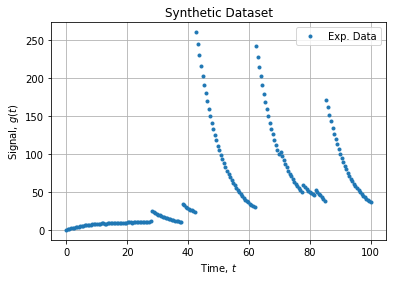

In [87]:
fig, axe = plt.subplots()
axe.plot(t1, x1k, '.', label='Exp. Data')
#axe.plot(t, x, '-', label='Exact')
axe.set_title("Synthetic Dataset")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Signal, $g(t)$")
axe.legend()
axe.grid()

In [88]:
dxdt = np.abs(np.diff(x1k)/np.diff(t1))

In [131]:
xit = 45

In [132]:
q1 = np.where(dxdt > xit)
q1

(array([ 75,  84, 123, 169], dtype=int64),)

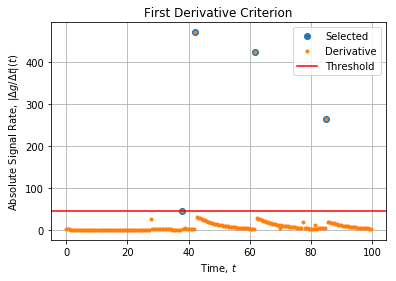

In [133]:
fig, axe = plt.subplots()
axe.plot(t1[q1[0]], dxdt[q1[0]], 'o', label='Selected')
axe.plot(t1[:-1], dxdt, '.', label='Derivative')
axe.axhline(xit, color="red", label='Threshold')
axe.set_title("First Derivative Criterion")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Absolute Signal Rate, $|\Delta g/\Delta t|(t)$")
axe.legend()
axe.grid()

In [134]:
idx1 = [0] + list(q1[0]+1) + [t1.size]
idx1

[0, 76, 85, 124, 170, 200]

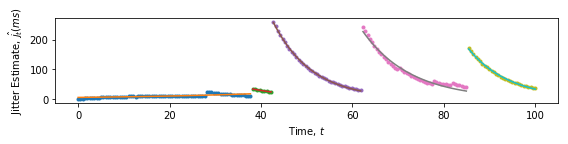

In [206]:
trials1k = []
fig, axe = plt.subplots(figsize=(8,2))
for k, (i, j) in enumerate(zip(idx1[:-1], idx1[1:])):
    p, s = optimize.curve_fit(func, t1[i:j]-t1[i], x1k[i:j])
    axe.plot(t1[i:j], x1k[i:j], '.', label="Data #{}".format(k+1))
    axe.plot(t1[i:j], func(t1[i:j]-t1[i], *p), label="Curve Fit #{}".format(k+1))
    trials1k.append({"n0": i, "n1": j, "t0": t1[i], "a": p[0], "b": p[1],
                   "s_a": s[0,0], "s_b": s[1,1], "s_ab": s[0,1]})
#axe.set_title("Curve Fits")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Jitter Estimate, $\hat{j_t}(ms)$")
#axe.axes.yaxis.set_ticks([])
#axe.legend()
fig.tight_layout()
fig.savefig('1k.pdf', format='pdf', dpi=2000);
#axe.grid()

In [ ]:
trials3 = []
fig, axe = plt.subplots(figsize=(8,2))
for k, (i, j) in enumerate(zip(idx3[:-1], idx3[1:])):
    p, s = optimize.curve_fit(func, t3[i:j]-t3[i], x3[i:j])
    axe.plot(t3[i:j], x3[i:j], 'o', markersize=5, label="Data #{}".format(k+1))
    axe.plot(t3[i:j], func(t3[i:j]-t3[i], *p), lw=2,label="Curve Fit #{}".format(k+1))
    trials3.append({"n0": i, "n1": j, "t0": t3[i], "a": p[0], "b": p[1],
                   "s_a": s[0,0], "s_b": s[1,1], "s_ab": s[0,1]})
#axe.set_title("Curve Fits for 3-state model")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Jitter Estimate, $\hat{j_t}(ms)$")
#axe.axes.yaxis.set_ticks([])
#axe.legend()
fig.tight_layout()
fig.savefig('3state.pdf', format='pdf', dpi=1500);
#axe.grid()

In [180]:
rmse1k = []
for i, j in zip(idx1[:-1], idx1[1:]):
    p, s = optimize.curve_fit(func, t1[i:j]-t1[i], x1k[i:j])
    rmse = np.sqrt(np.mean((x1k[i:j]-func(t1[i:j]-t1[i], *p))**2))
    rmse1k.append({"n0": i, "n1": j, "rmse": rmse})

In [181]:
df1k = pd.DataFrame(rmse1k)
df1k

,n0,n1,rmse
0,0,76,3.217955
1,76,85,0.181283
2,85,124,1.308387
3,124,170,8.696130
4,170,200,1.522169


In [182]:
df1k['rmse'].sum()

14.925923913085219

In [212]:
mae1k = []

for i, j in zip(idx1[:-1], idx1[1:]):
    p, s = optimize.curve_fit(func, t1[i:j]-t1[i], x1k[i:j])
    mae = mean_absolute_error(x1k[i:j],(func(t1[i:j]-t1[i], *p)))
    mae1k.append({"n0": i, "n1": j, "mae": mae})

In [213]:
df1kmae = pd.DataFrame(mae1k)
df1kmae['mae'].sum()

12.307423452341302

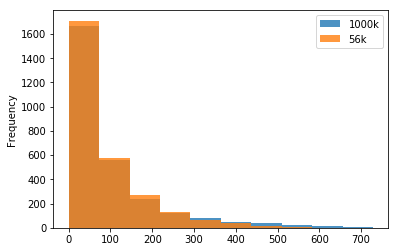

In [146]:
df[["1000k", "56k"]].plot.hist(alpha=0.8) 

In [142]:
df.head()

,1000k,56k
Time,,
0,0.000000,0.000000
1,0.689965,1.464125
2,1.341377,1.755673
3,1.951819,2.027818
4,2.523677,2.285573


In [149]:
df.describe()

,1000k,56k
count,2812.000000,2812.000000
mean,100.366901,87.065985
std,117.863522,92.183005
min,0.000000,0.000000
25%,27.133667,25.308020
50%,55.428981,53.585849
75%,122.712843,115.294356
max,728.661757,583.917779


In [171]:
df['56k'].std()

92.18300453357871

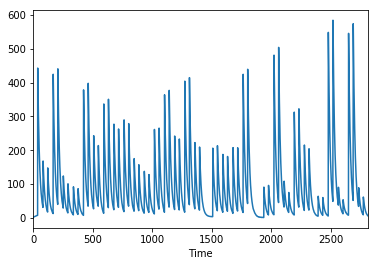

In [169]:
df['56k'].plot()

In [173]:
x=[0.09, 0.95, 0.93, 0.93, 0.34, 0.29, 0.14, 0.23, 0.91, 0.31, 0.62,
       0.29, 0.71, 0.26, 0.79, 0.3 , 0.1 , 0.73, 0.63, 0.61]

x=pd.DataFrame(x)

In [175]:
x.describe()

,0
count,20.00000
mean,0.50800
std,0.30277
min,0.09000
25%,0.28250
50%,0.47500
75%,0.74500
max,0.95000


Text(2.140131222101623, 131.355, 'Mean: 1.95')

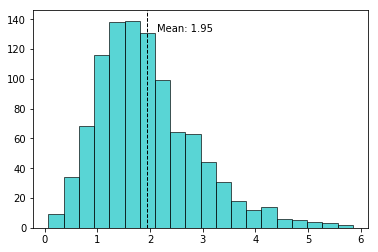

In [17]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(6789)
x = np.random.gamma(4, 0.5, 1000)
result = plt.hist(x, bins=20, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(x.mean()))

In [18]:
df.columns

Index(['1000k', '56k'], dtype='object')

Text(110.40359156136606, 957.2850000000001, 'Mean: 100.37')

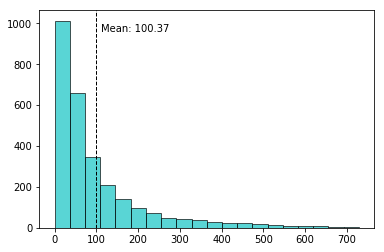

In [23]:

x = np.random.gamma(4, 0.5, 1000)
res_1k = plt.hist(df['1000k'], bins=20, color='c', edgecolor='k', alpha=0.65)
plt.axvline(df['1000k'].mean(), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(df['1000k'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df['1000k'].mean()))

Text(95.77258321080838, 776.7900000000001, 'Mean: 87.07')

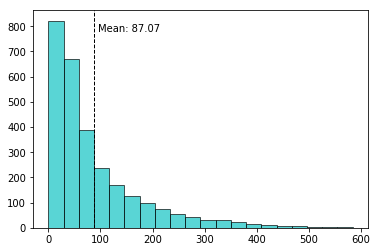

In [24]:

x = np.random.gamma(4, 0.5, 1000)
res_1k = plt.hist(df['56k'], bins=20, color='c', edgecolor='k', alpha=0.65)
plt.axvline(df['56k'].mean(), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(df['56k'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df['56k'].mean()))

In [19]:
df['1000k'].mean()

100.36690141942368

In [20]:
x.mean()

1.9455738382742025

In [21]:
x.mean()*1.1

2.140131222101623

(0.0, 1.0)

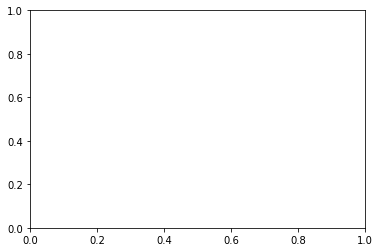

In [22]:
plt.ylim()

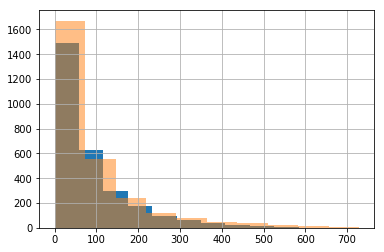

In [35]:
df['56k'].hist();
df['1000k'].hist(alpha=0.5);

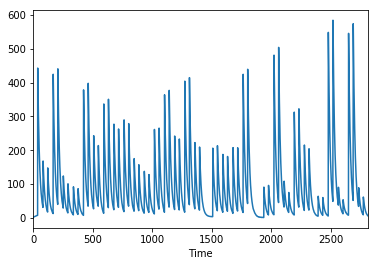

In [37]:
df['56k'].plot()

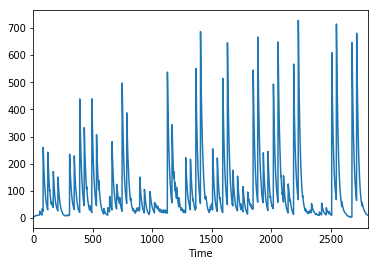

In [70]:
df['1000k'].plot()

In [42]:
df['56k'][:40].values

array([  0.        ,   1.464125  ,   1.75567274,   2.0278182 ,
         2.28557261,   2.52803683,   2.75221508,   2.96407664,
         3.1631899 ,   3.35086554,   3.52611699,   3.69129718,
         3.84245916,   3.98755547,   4.1231388 ,   4.25038013,
         4.43948832,   4.7097703 ,   4.9640416 ,   5.2016015 ,
         5.42500835,   5.63382033,   5.828651  ,   6.01217281,
         6.18185646,   6.34299043,   6.49512297,   6.63674029,
         6.76975652,   6.89496618,   7.01178079,   7.12192644,
         7.22199354,   7.31843838,   7.40903599,   7.49479068,
         7.57442876,   7.64959641,   7.71662163, 442.6212286 ])

In [46]:
a = df['56k'].values

In [55]:
for i in a[38:42]:
    print (i)

7.716621634
442.62122860000005
415.14907539999996
389.3954318


In [52]:
a1 = a[:39]

In [56]:
for i in a[39:]

array([0.        , 1.464125  , 1.75567274, 2.0278182 , 2.28557261,
       2.52803683, 2.75221508, 2.96407664, 3.1631899 , 3.35086554,
       3.52611699, 3.69129718, 3.84245916, 3.98755547, 4.1231388 ,
       4.25038013, 4.43948832, 4.7097703 , 4.9640416 , 5.2016015 ,
       5.42500835, 5.63382033, 5.828651  , 6.01217281, 6.18185646,
       6.34299043, 6.49512297, 6.63674029, 6.76975652, 6.89496618,
       7.01178079, 7.12192644, 7.22199354, 7.31843838, 7.40903599,
       7.49479068, 7.57442876, 7.64959641, 7.71662163])

In [59]:
a[39:]

array([442.6212286 , 415.1490754 , 389.3954318 , ...,   7.20198522,
         6.76682642,   6.38636505])

In [77]:
a2 = [i/2 for i in a[39:]]

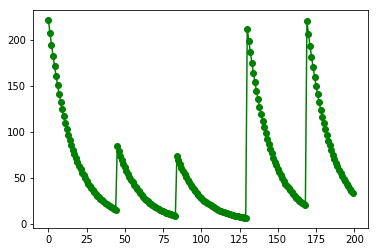

In [79]:
plt.plot(a2[:200],'g-o')

In [81]:
max(a2)

291.95888925

In [119]:
mc = np.concatenate((a1,a2))

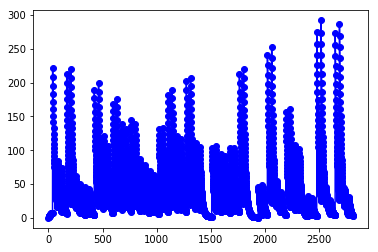

In [120]:
plt.plot(mc,'b-o')

In [92]:
np.mean(mc)

43.567445981623926

In [97]:
df_inter = pd.DataFrame()

In [98]:
df_inter['Time'] = np.arange(0,len(mc))
df_inter['Jitter'] = mc

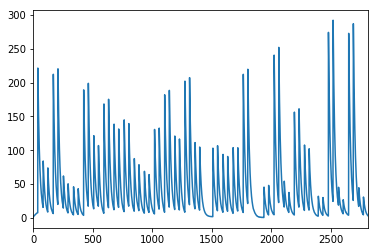

In [101]:
df_inter['Jitter'].plot()

In [103]:
df_inter.to_csv('intermediate_df.csv',index=False)
#save for later use as intermediate range congestion

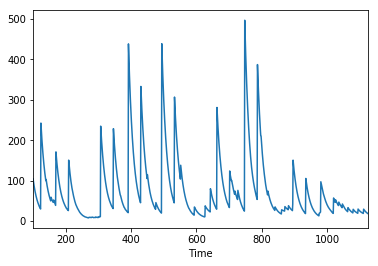

In [112]:
df['1000k'][100:1126].plot()

In [113]:
b1 = df['1000k'][100:1126].values

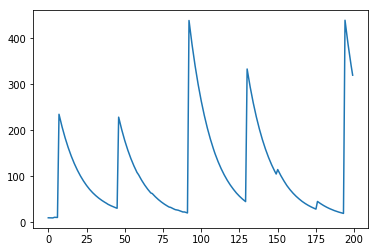

In [116]:
plt.plot(b1[200:400])

In [115]:
len(b1)

1026